# Import necessary packages

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw
# import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Autumn 2022/CS 230/Project/Project Code/DL_Track-master

/content/drive/MyDrive/Autumn 2022/CS 230/Project/Project Code/DL_Track-master


## Define custom functions

In [ ]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

## APONEUROSIS TRAINING

# Set image scaling parameters, determine no. of images for training

In [ ]:
# Images will be re-scaled
im_width = 512
im_height = 512
border = 5
print(os.listdir())
# walk_ = os.walk("apo_images")

# list of all images in the path
ids = [filename for filename in os.listdir("apo_images") if not "(" in filename]


print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

['requirements.txt', 'home_im.png', 'COLAB_Inference_Video.ipynb', 'Supp_video_1.mp4', 'python_setup.md', 'Inference_Video.ipynb', 'colab_instructions.md', 'README.md', 'COLAB_Inference_Single_Image.ipynb', 'Labelling_Instructions.pdf', 'LICENSE', 'apo_images', 'models', 'fasc_images_S', 'fasc_masks_S', 'apo_masks', 'DL_Track', 'apo2_weights.csv', 'model-apo2-nc.h5', 'fasc2_training_losses.csv', 'model-fascSnippets2-nc.h5', 'model-apo2-nc_TEST.h5', 'apo2_weights_TEST.csv', 'metric_results', 'metric_results.xlsx', 'Inference_Single_Image.ipynb', 'VGG16implementation.ipynb', 'Model_Training.ipynb']
Total no. of aponeurosis images =  574


# Load images and corresponding labels (masks)

In [ ]:
ids.sort()

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("apo_images/"+id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("apo_masks/"+id_, color_mode='grayscale'))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-8-3a3bdb43f914>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/574 [00:00<?, ?it/s]

# Set up aponeurosis training

In [ ]:
# Split data into training and validation
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split

Text(0.5, 1.0, 'Mask only')

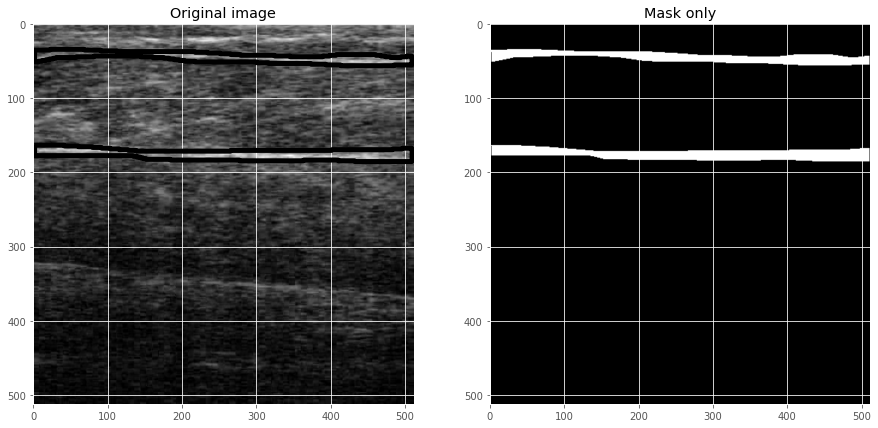

In [ ]:
# Visualize a random image along with the mask (not necessary, just for checking)
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Check whether there's at least 1 aponeurosis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if at least 1 aponeurosis is present
    # draw the aponeuroses on the original image
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Original image')
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask only')

In [ ]:
# Compile the aponeurosis model
input_img = Input((im_height, im_width, 1), name='img')
model_apo = get_unet(input_img, n_filters=64, dropout=0.25, batchnorm=True)
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [ ]:
print(input_img)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name='img'), name='img', description="created by layer 'img'")


In [ ]:
# Show a summary of the model structure
model_apo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  640         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512, 512, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
# Set some training parameters
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-apo2-nc.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('apo2_weights_TEST.csv', separator=',', append=False)
]

In [ ]:
!pwd

/content/drive/MyDrive/Autumn 2022/CS 230/Project/Project Code/DL_Track-master


# Train the aponeurosis model (keep batch size small!)

In [ ]:
results = model_apo.fit(X_train, y_train, batch_size=2, epochs=1, callbacks=callbacks, validation_data=(X_valid, y_valid))

258/258 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9668 - IoU: 0.9315
Epoch 1: val_loss improved from inf to 0.06601, saving model to model-apo2-nc_TEST.h5
258/258 [==============================] - 118s 389ms/step - loss: 0.1250 - accuracy: 0.9668 - IoU: 0.9315 - val_loss: 0.0660 - val_accuracy: 0.9751 - val_IoU: 0.9754 - lr: 0.0010


## Visualise the results of training

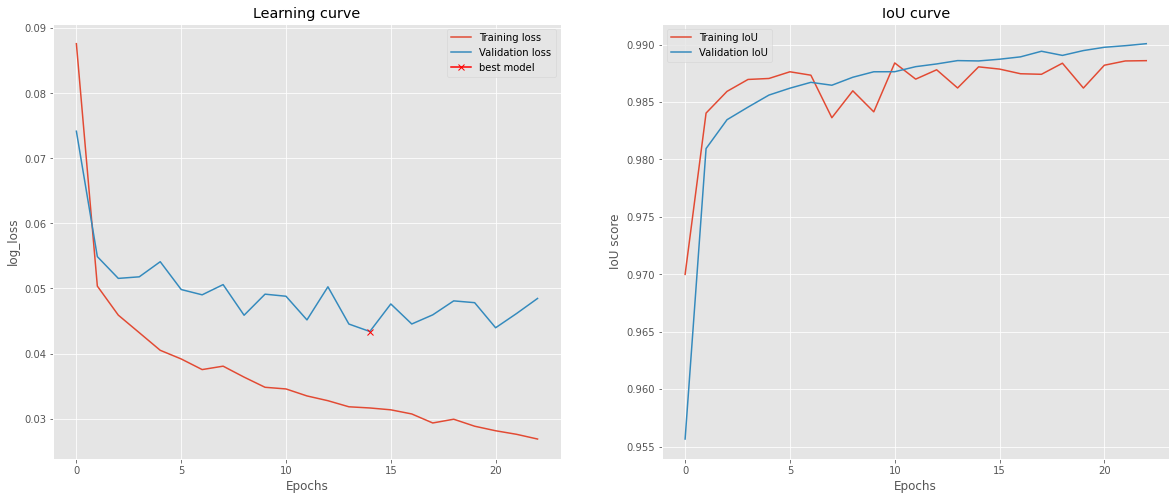

In [ ]:
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

In [ ]:
# results.history # Show the loss values (these are saved to a .csv file using 'CSVLogger' callback defined above)

In [ ]:
# Predict on training and validations sets
# only predicting for first 10 because of memory issue
print(X_train.shape)
preds_train = model_apo.predict(X_train[:10,:,:,:], verbose=1)
preds_val = model_apo.predict(X_valid[:10,:,:,:], verbose=1)

# Threshold predictions (only keep predictions with a minimum level of confidence)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

NameError: ignored

In [ ]:
print(preds_val_t)

NameError: ignored

## END OF APONEUROSIS MODEL TRAINING - NOW USE THE TRAINED MODEL BY RUNNING ONE OF THE INFERENCE NOTEBOOKS

# Start of Fascicle Training

In [ ]:
# list of names of all images in the given path
im_width = 512
im_height = 512
idsF = next(os.walk("fasc_images_S"))[2] 
print("Total no. of fascicle images = ", len(idsF))
XF = np.zeros((len(idsF), im_height, im_width, 1), dtype=np.float32)
yF = np.zeros((len(idsF), im_height, im_width, 1), dtype=np.float32)

Total no. of fascicle images =  309


# Load images and corresponding fascicle masks

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(idsF), total=len(idsF)):
    # Load images
    imgF = load_img("fasc_images_S/"+id_, color_mode = 'grayscale')
    x_imgF = img_to_array(imgF)
    x_imgF = resize(x_imgF, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    maskF = img_to_array(load_img("fasc_masks_S/"+id_, color_mode = 'grayscale'))
    maskF = resize(maskF, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    XF[n] = x_imgF/255.0
    yF[n] = maskF/255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/309 [00:00<?, ?it/s]

# Set up fascicle training

In [ ]:
# Split data into training and validation
# X_trainF, X_validF, y_trainF, y_validF = train_test_split(XF, yF, test_size=0.1, random_state=42)
X_trainF, X_validF, y_trainF, y_validF = train_test_split(XF, yF, test_size=0.1)

In [ ]:
# Compile the model
input_imgF = Input((im_height, im_width, 1), name='img')
modelF = get_unet(input_imgF, n_filters=32, dropout=0.25, batchnorm=True)
modelF.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [ ]:
# Set some training parameters (e.g. the name you want to give to your trained model)
callbacksF = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-fascSnippets2-nc.h5', verbose=1, save_best_only=True, save_weights_only=False), # Name your model (the .h5 part)
    CSVLogger('fasc2_training_losses.csv', separator=',', append=False)
]

# Train the fascicle model

In [ ]:
resultsF = modelF.fit(X_trainF, y_trainF, batch_size=2, epochs=50, callbacks=callbacksF,\
                    validation_data=(X_validF, y_validF))

Epoch 1/50
139/139 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.9377 - IoU: 0.8277
Epoch 1: val_loss improved from inf to 0.10956, saving model to model-fascSnippets2-nc.h5
139/139 [==============================] - 27s 157ms/step - loss: 0.2768 - accuracy: 0.9377 - IoU: 0.8277 - val_loss: 0.1096 - val_accuracy: 0.9907 - val_IoU: 0.9122 - lr: 0.0010
Epoch 2/50
139/139 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9921 - IoU: 0.9343
Epoch 2: val_loss improved from 0.10956 to 0.04296, saving model to model-fascSnippets2-nc.h5
139/139 [==============================] - 21s 150ms/step - loss: 0.0799 - accuracy: 0.9921 - IoU: 0.9343 - val_loss: 0.0430 - val_accuracy: 0.9908 - val_IoU: 0.9665 - lr: 0.0010
Epoch 3/50
139/139 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9921 - IoU: 0.9676
Epoch 3: val_loss improved from 0.04296 to 0.03126, saving model to model-fascSnippets2-nc.h5
139/139 [=========================

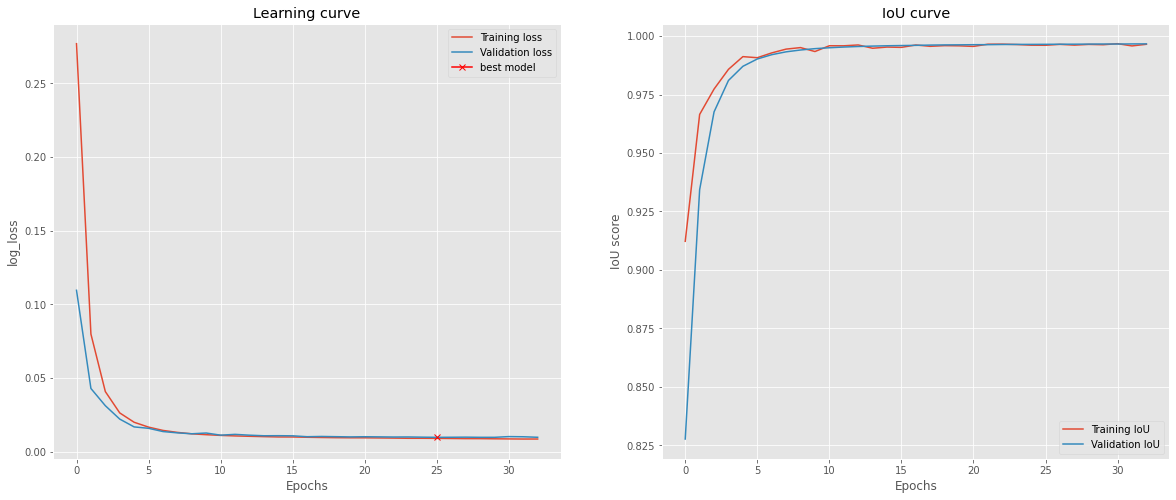

In [ ]:
# Visualise the results of training
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(resultsF.history["loss"], label="Training loss")
ax[0].plot(resultsF.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(resultsF.history["val_loss"]), np.min(resultsF.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(resultsF.history["val_IoU"], label="Training IoU")
ax[1].plot(resultsF.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

In [ ]:
# # Evaluate on validation set (loss, acc, IoU)
# modelF.evaluate(X_validF, y_validF, verbose=2)

In [ ]:
# Predict on training and validations sets
preds_trainF = modelF.predict(X_trainF, verbose=1)
preds_valF = modelF.predict(X_validF, verbose=1)

# Threshold predictions (only keep predictions with a minimum level of confidence)
preds_train_tF = (preds_trainF > 0.5).astype(np.uint8)
preds_val_tF = (preds_valF > 0.5).astype(np.uint8)

1/1 [==============================] - 11s 11s/step
